# Сегментация
В этот раз мы рассмотрим чуть менее стандартную задачу - сегментации изображений.


In [97]:
import math
import os
import warnings
from typing import Dict, List, Tuple

import albumentations as A
import cv2
import numpy as np
import random
import torch
import tqdm
import wandb
from PIL import Image
from torch import nn

import matplotlib.pyplot as plt
import torchmetrics
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torchvision import transforms
import albumentations.pytorch
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2


warnings.filterwarnings("ignore")

In [98]:
base_dir = r"../../data/archive/aeroscapes"
device = "cuda" if torch.cuda.is_available() else "cpu"

Для начала рассмотрим датасет изображений, полученных с дрона на высоте от 5 до 50 метров.

In [99]:
LABEL_NAMES = ['Background', 'Person', 'Bike', 'Car', 'Drone', 'Boat', 'Animal', 'Obstacle', 'Construction', 'Vegetation', 'Road', 'Sky']

COLOR_MAPPING = {
    (0, 0, 0): 0,  # Background
    (192, 128, 128): 1,      # Person
    (0, 128, 0): 2,          # Bike
    (128, 128, 128): 3,      # Car
    (128, 0, 0): 4,          # Drone
    (0, 0, 128): 5,          # Boat
    (192, 0, 128): 6,        # Animal
    (192, 0, 0): 7,          # Obstacle
    (192, 128, 0): 8,        # Construction
    (0, 64, 0): 9,           # Vegetation
    (128, 128, 0): 10,       # Road
    (0, 128, 128): 11,       # Sky
}


Сегментация - это та же классификация. Разница с обычным кейсом лишь в том, что классифицируется каждый пиксель изображенияю Поэтому вместо приятной структуры с папками нам придется вернуться к рукописным датасетам.

Создадим датасет: он будет читать файлы из папок с изображениями и масками. Маски трехмерные, но мы знаем их маппинг в классы. Так что легко можно поменять маску на номер желаемого класса. Остальное стандартно - трансформируем семпл, возвращаем результат.

Сейчас немного усложним задачу, будем читать из папки Visualizations, а не SegmentationMasks (но вы можете и оттуда сразу читать, конечно)

In [100]:
class AerialSegmentationDataset(Dataset):
    def __init__(self, root, data = "trn", transformations = None):
        files = open(f"{root}/ImageSets/{data}.txt", "r").read().split("\n")
        self.im_paths, self.gt_paths = self.get_data_paths(root = root, files = files) 
        self.transformations = transformations
        self.n_cls = 11
        print(len(self.im_paths), len(self.gt_paths))
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): 
        return len(self.im_paths)

    def __getitem__(self, idx):
        im = self.read_image(self.im_paths[idx])
        mask = cv2.imread(self.gt_paths[idx], cv2.IMREAD_COLOR)
        mask = convert_mask(mask)
        if self.transformations: 
            # Проведите трансформации
            transformed = self.transformations(image=im, mask=mask )
            im, mask = transformed["image"], transformed["mask"]
        return im, mask
        
    def get_data_paths(self, root, files) -> tuple[list[str], list[str]]: 
        images = [
            path for path in sorted(glob(f"{root}/JPEGImages/*.jpg")) if self.get_fname(path) in files]
        masks =  [
            path for path in sorted(glob(f"{root}/Visualizations/*.png")) if self.get_fname(path) in files]
        return images, masks 
       
    def get_fname(self, path): 
        return os.path.splitext(os.path.basename(path))[0]

    def read_image(self, path): 
        return cv2.cvtColor(
            cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB
        )

def convert_mask(mask_rgb):
    mask = np.zeros((mask_rgb.shape[0], mask_rgb.shape[1]), dtype=np.uint8)
    for rgb, idx in COLOR_MAPPING.items():
        mask[(mask_rgb == rgb).all(axis=2)] = idx
    return mask
 

Создадим инстанс датасета для визуализации. 

In [101]:
im_h, im_w = 256, 256
transformations = A.Compose( [A.Resize(im_h, im_w), ToTensorV2(transpose_mask = True) ])

train_dataset = AerialSegmentationDataset(root=base_dir, data="trn", transformations=transformations)
test_dataset = AerialSegmentationDataset(root=base_dir, data="val", transformations=transformations)
n_cls = train_dataset.n_cls

2621 2621
648 648


Добавим функции для того, чтобы красиво нарисовать наши примеры

In [102]:
def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    plt.subplot(rows, cols, count)
    image = im.squeeze(0).int().permute(1,2,0) if not gt else im.squeeze(0).float()
    plt.imshow(image)
    plt.axis("off"); plt.title(title)
    return count + 1
    
def visualize(ds, n_ims):
    plt.figure(figsize = (25, 20))
    rows = n_ims // 4; cols = n_ims // rows
    count = 1
    indices = [random.randint(0, len(ds)) for _ in range(n_ims)]
    for idx, index in enumerate(indices):
        if count == n_ims + 1: break
        im, gt = ds[index]
        # First Plot
        count = plot(rows, cols, count, im = im)
        # Second Plot
        count = plot(rows, cols, count, im = gt, gt = True, title="Segmentation mask")

И нарисуем

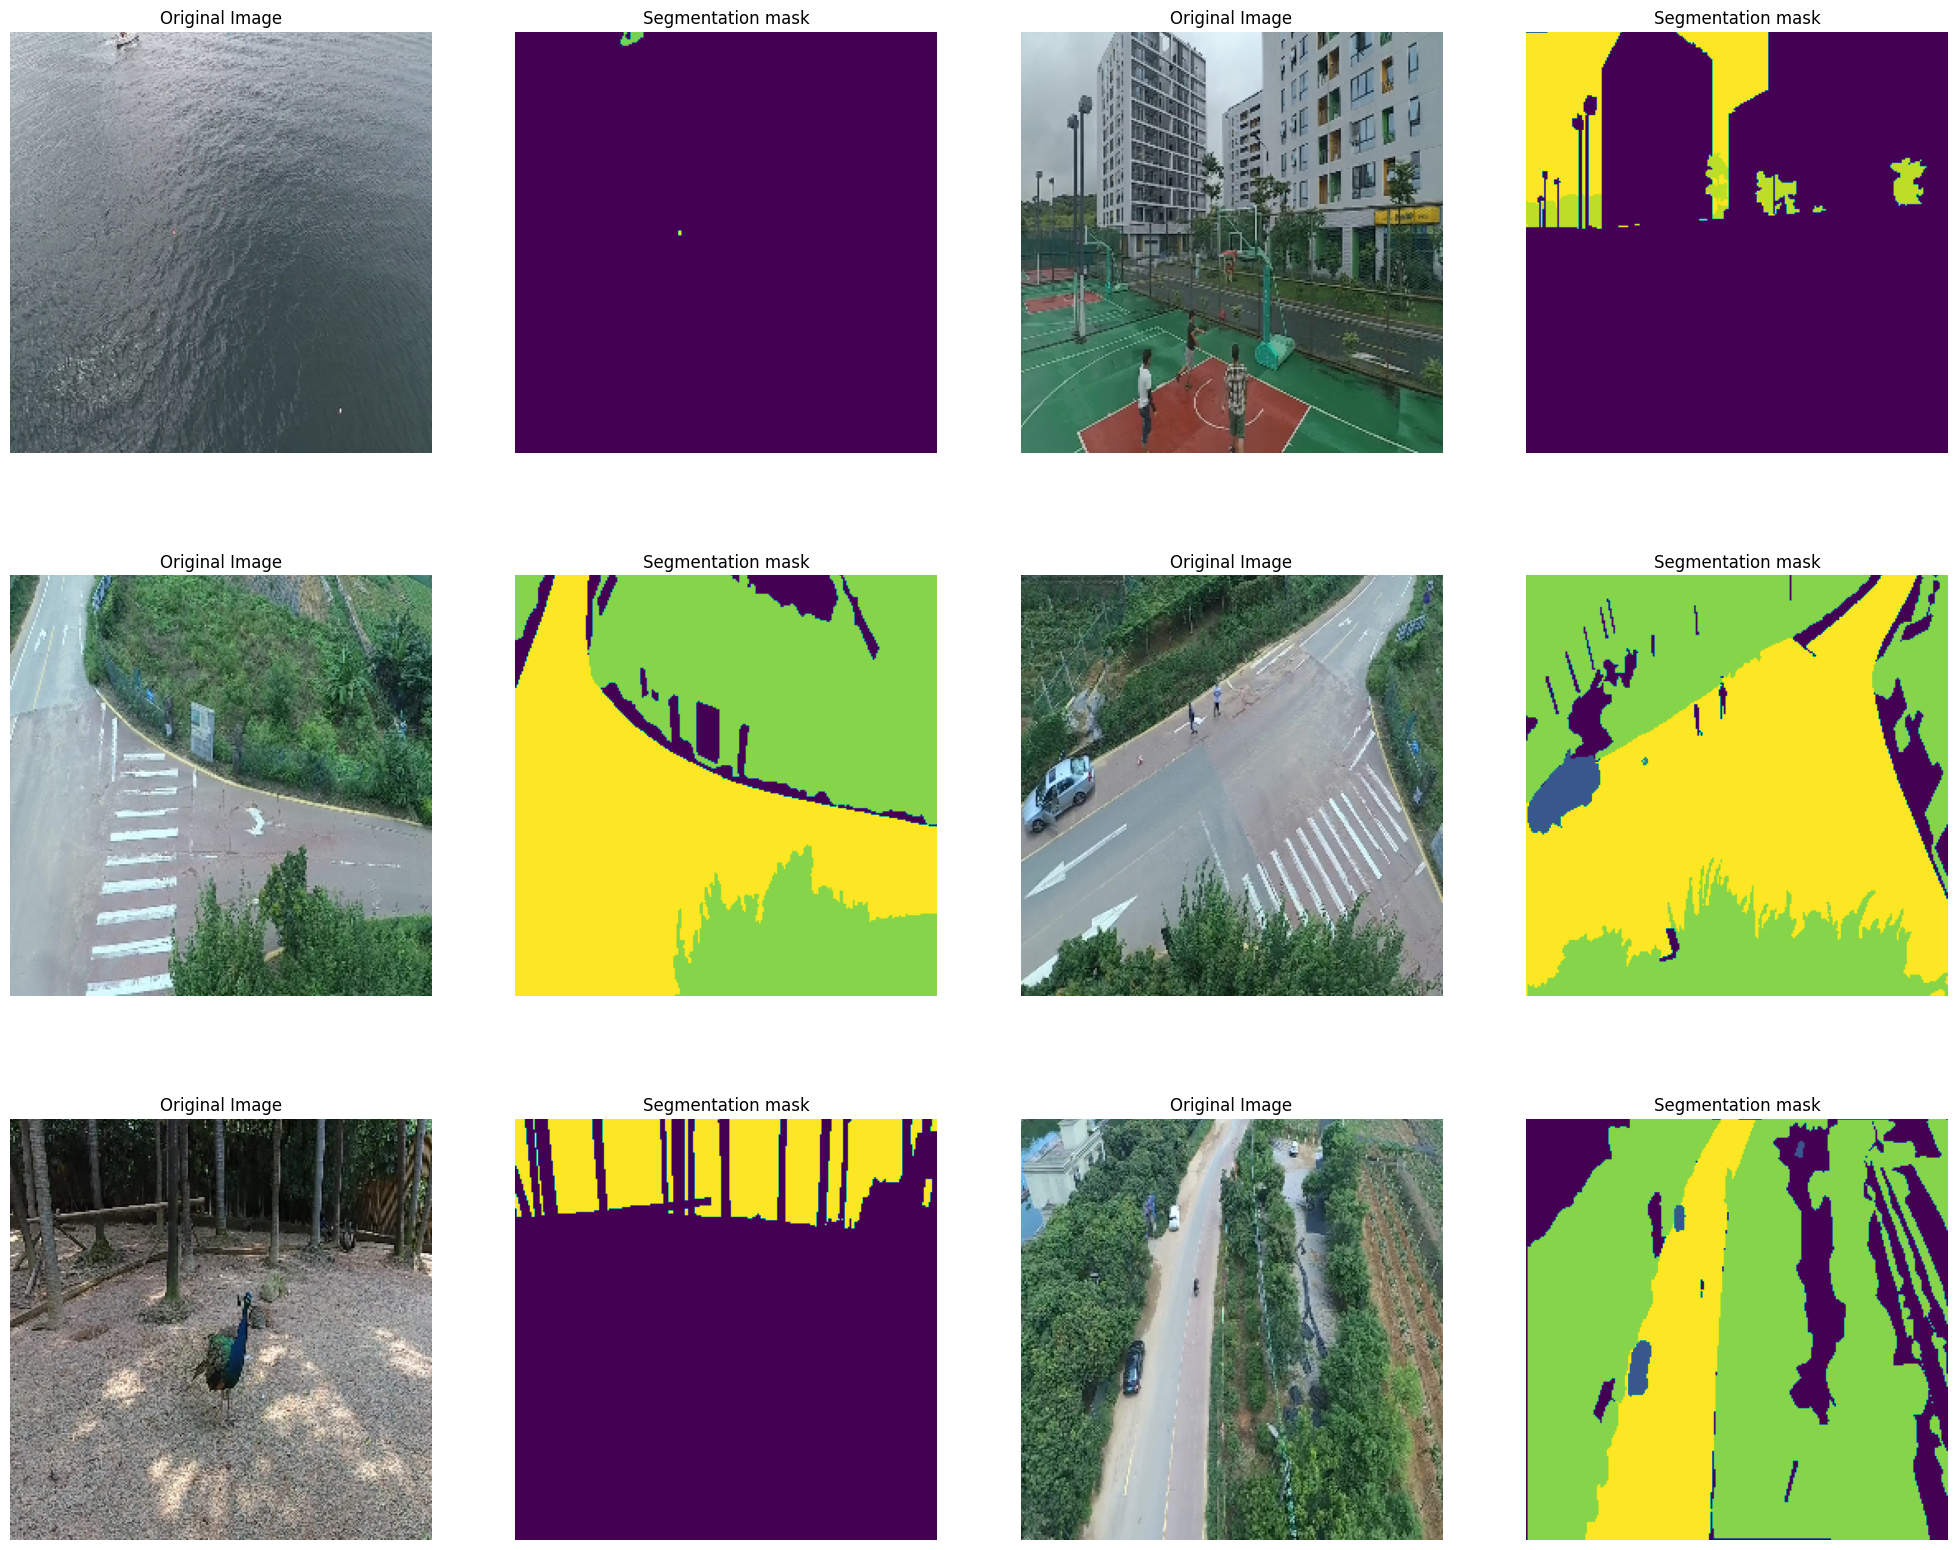

In [103]:
visualize(train_dataset, 12)

Дополнительное задание: выведите исходные пары изображение - трехканальная маска

Теперь уже создадим наш датасет, а также разобьем его на трейн-валидацию-тест

**Допзадание**: попробуйте еще другие аугментации

In [104]:
mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
transformations = A.Compose( [
    A.Resize(im_h, im_w),
    A.augmentations.transforms.Normalize(mean = mean, std = std), 
    ToTensor(),
    ToTensorV2(transpose_mask = True)
])

split = [0.9, 0.1]
batch_size = 16

# создайте датасеты для теста и валидации

train_len = int(len(train_dataset)*split[0]) # Определите обучающую длину
val_len = int(len(train_dataset)*split[1])+1 # Определите валидационную длину

# Data split
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])
    
print(f"\nThere are {len(train_dataset)} number of images in the train set")
print(f"There are {len(val_dataset)} number of images in the validation set")
print(f"There are {len(test_dataset)} number of images in the test set\n")

# Get dataloaders
train_dataloader  = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = False)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle = False)



There are 2358 number of images in the train set
There are 263 number of images in the validation set
There are 648 number of images in the test set



Теперь создадим нашу архитектуру. Это [UNet](https://arxiv.org/pdf/1505.04597) - одна из базовых архитектур для сегментацию, аналоги которой еще и активно используются в самых разных приложениях.

Задание: дополните код, чтобы получить UNet с двумя внутренними блоками. 
Минимальная задача для слабых компьютеров - максимальное число фичей - 128. В таком случае мы будем использовать только по два блока, а не 4 исходных.

Исходная архитектура:
![alt_text](../../additional_materials/images/u-net-architecture.png)

# Как реализовать up-conv?
В torch для этого есть nn.TransposeConv2d. 
На самом деле это не совсем свертка - она берет входные значения и вначале создает что-то вроде буфера, где хранит результаты умножения ядра на вход поэлементно. После того, как все результаты получены, они собираются воедино суммированием (можно посмотреть подробное объяснение [здесь](https://stackoverflow.com/questions/69782823/understanding-the-pytorch-implementation-of-conv2dtranspose):

![alt_text](../additional_materials/images/tc1.png)

Примеры:
![alt_text](../additional_materials/images/tc2.png)

![alt_text](../additional_materials/images/tc3.png)

![alt_text](../additional_materials/images/tc4.png)


In [105]:
class ConvBlock(nn.Module):
    # YOUR CODE OF BLOCK
    # Note that the hxw must stay the same
    def __init__(self, in_channels, out_channels, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding= 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding= 1)

    def forward(self, x:torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        out_channels: int = 1,
        features: List[int] = [32, 64, 128],
    ):
        super().__init__()
        self.down = nn.ModuleList()
        self.up = nn.ModuleList()
        self.pool = nn.MaxPool2d(2, 2) # Phase change - from down to up
        ch = in_channels
        for i in features:
            self.down.append(ConvBlock(ch, i))
            ch = i
        # append blocks:
            # append blocks to down part
            # features x2 in out
        for i in reversed(features):
            self.up.append(nn.ConvTranspose2d(in_channels= i *2, out_channels=i, kernel_size=2, stride=2))
            self.up.append(ConvBlock(i*2, i))
        #append blocks in reversed order:
            # append pairs of (transposed convolutions and blocks to up)
            # features /2 in out
        self.bottleneck = ConvBlock(ch, ch*2)# your code
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)# your code

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        skip_connections = []  # storage for skip connections
        for down in self.down:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            # add forwards and also fill skip connections
        
        x = self.bottleneck(x) # add bottleneck
        skip_connections = skip_connections[::-1]# reverse list of skip connections
        for idx in range(0, len(self.up), 2):
            x = self.up[idx](x)
            skip = skip_connections[idx//2]
            # run up and also get corresponding skip
            # if shape of x and skipped x are different, don't forget to reshape x
            if x.shape !=skip.shape:
                skip = transforms.Resize(x.shape)(skip)
            concat_skip = torch.cat((skip,x), dim=1)# Concat skip and x along channels dimensions (b, c, h, w)
            x = self.up[idx+1](concat_skip)# call next block with skip
        return self.final_conv(x) # call final conv

Создадим модель

In [106]:
model = UNet(out_channels=n_cls+1)

Теперь немного подушним с метриками. Для сегментации и детекции они похожи, так как обе задачи требуют определения целевых регионов. Поэтому наиболее естественны метрики, основанные на геометрии.
Рассмотрим две: IoU и Dice. 
![alt_text](../additional_materials/images/metrics.png)

Так как у нас задача мультиклассовая, мы должны посчитать эти метрики по классам и усреднить результат.

**Задание**: Дополните код, реализовав метрики mIoU и Dice.


Для того, чтобы можно было в будущем сочетать наши рукописные метрики и торчовые, напишем обертку, которая хранит в себе словарь со всем метриками сразу. Каждая рукописная должна иметь те же методы, что и torchmetrics.Metric: __call__ и compute()


In [107]:
from abc import ABC, abstractmethod
from typing import Iterable, Dict

class Metric(ABC):
    def __init__(self):
        self._values = []

    def __call__(self, preds: Iterable, targets: Iterable) -> float:
        value = self.compute_metric(preds, targets)
        self._values.append(value)
        return value

    @abstractmethod
    def compute_metric(self, preds: Iterable, targets: Iterable) -> float:
        pass

    def compute(self) -> float:
        if not self._values:
            return 0.0
        mean_value = sum(self._values) / len(self._values)
        return mean_value

    def reset(self):
        self._values = []


class MetricCollection:
    def __init__(self, metrics: Dict[str, Metric | torchmetrics.Metric]):
        if not isinstance(metrics, dict):
            raise TypeError("metrics must be a dictionary of Metric instances.")
        for name, metric in metrics.items():
            if not isinstance(metric, Metric) and not isinstance(metric, torchmetrics.Metric):
                raise TypeError(
                    f"Value for '{name}' is not an instance of Metric (handmade or torchmetrics)."
                )
        self.metrics = metrics

    def __call__(self, preds: Iterable, targets: Iterable) -> Dict[str, float]:
        computed_values = {}
        for name, metric in self.metrics.items():
            computed_values[name] = metric(preds, targets)
        return computed_values

    def compute(self) -> Dict[str, float]:
        computed_values = {}
        for name, metric in self.metrics.items():
            computed_values[name] = metric.compute()
        return computed_values

    def reset(self):
        for _, metric in self.metrics.items():
            metric.reset()

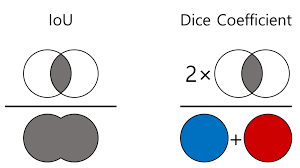

In [108]:
class MeanIntersectionOverUnion(Metric):
    def __init__(self, num_classes: int, eps: float = 1e-6):
        super().__init__()
        self.num_classes = num_classes

    def compute_metric(self, preds: torch.Tensor, targets: torch.Tensor) -> float:
        preds = torch.argmax(preds, dim=1)
        iou_per_class = []
        for c in range(self.num_classes):
            true_positive = ((targets == c) & (preds == c)).sum()
            union = ((targets == c) | (preds == c)).sum() - true_positive
            iou = (true_positive+ 1e-6) / (union+ 1e-6)
            iou_per_class.append(iou)
        return np.mean(iou_per_class)

class DiceScore(Metric):
    def __init__(self, num_classes: int):
        super().__init__()
        self.num_classes = num_classes

    def compute_metric(self, preds: torch.Tensor, targets: torch.Tensor) -> float:
        preds = torch.argmax(preds, dim=1)
        dice_per_class = []
        for c in range(self.num_classes):
            intersection = ((targets == c) & (preds == c)).sum()
            total = (targets == c).sum() + (preds == c).sum()
            dice = (2 * intersection+ 1e-6) / (total + 1e-6)
            dice_per_class.append(dice)
        return np.mean(dice_per_class)


Зададим лосс и оптимизатор. У нас еще задача не очень сложная, можем воспользоваться кросс-энтропией.

**Доп.задание**: создайте лосс из Dice Score. Обучите модель с новым лоссом. Как меняется результат? Объясните, почему можно сделать лосс из Dice Score, но не выйдет из IoU

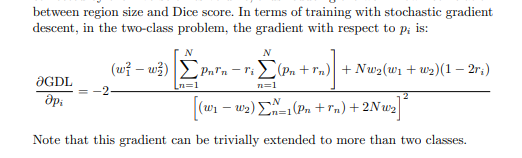

In [109]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
            model.parameters(), lr=0.001, weight_decay=0.3
        )

In [110]:
metrics = MetricCollection({"mIoU": MeanIntersectionOverUnion(n_cls), "dice": DiceScore(n_cls)})

In [111]:
from collections import namedtuple

LossInfo = namedtuple(
    "LossInfo", ["full_train_losses", "train_epoch_losses", "eval_epoch_losses"]
)
EPOCHS = 10
LR = 0.001

In [112]:
def train_epoch(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metrics: MetricCollection, 
    optimizer: torch.optim.Optimizer,
    binary: int | None = None,
    return_losses=False,
):
    model = model.train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            # YOUR CODE
            # train step: preds, loss, optimization, etc   
            preds = model(inputs.float())
            preds = preds.reshape(preds.shape[0], preds.shape[1], -1)
            targets = targets.reshape(targets.shape[0],-1).type(torch.LongTensor)
            loss = criterion(preds, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()         
            metrics_dict = metrics(preds, targets)
            metrics_desc = ",".join([f"{i}: {v:.4}" for i,v in metrics_dict.items()])
            # update description for tqdm
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} " + metrics_desc
            )
            prbar.update(1)
            total_loss += loss.item()
            num_batches += 1
            all_losses.append(loss.detach().item())
    metric_values = metrics.compute()
    if return_losses:
        return metric_values, all_losses
    else:
        return metric_values

In [113]:
def validate(
        model: nn.Module,
        data_loader: torch.utils.data.DataLoader,
        criterion: nn.Module,
        metrics: MetricCollection,
        binary: bool | None = None,
        device: str = "cuda:0"):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    with tqdm.tqdm(total=len(data_loader)) as prbar:
        for inputs, targets in data_loader:
            with torch.no_grad():
                model.eval()
                preds = model(inputs)
                loss = criterion(preds, targets)
                total_loss += loss
            metrics_dict = metrics(preds, targets)
            metrics_desc = ",".join([f"{i}: {v:.4}" for i,v in metrics_dict.items()])
            prbar.set_description(
                f"Loss: {loss.item():.4} " + metrics_desc
            )
            prbar.update(1)
            total_loss += loss.item()
            
            num_batches += 1
    return {**metrics.compute(), "loss": loss}

In [114]:
def train(
    model: nn.Module,
    epochs: int,
    train_data_loader: torch.utils.data.DataLoader,
    validation_data_loader: torch.utils.data.DataLoader,
    criterion: nn.Module,
    metrics: MetricCollection,
    optimizer: torch.optim.Optimizer,
    scheduler=None,
    binary: int | None = None,
    device="cuda:0",
):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # construct iterators
        train_iterator = iter(train_data_loader)
        validation_iterator = iter(validation_data_loader)
        # train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_iterator,
            criterion=criterion,
            metrics=metrics,
            optimizer=optimizer,
            binary=binary,
            return_losses=True,
        )
        # save train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics["loss"])
        # eval step
        print(f"Validation Epoch: {epoch}")

        # call function validation epoch and
        # save eval losses
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_iterator,
                criterion=criterion,
                metrics=metrics,
                binary=binary,
                device=device
            )
        # save eval losses
        epoch_eval_losses.append(validation_metrics["loss"])
        # scheduler step
        if scheduler:
            scheduler.step()
    return LossInfo(all_train_losses, epoch_train_losses, epoch_eval_losses)

In [115]:
model.to(device)
_ = train(
    model=model,
    epochs=5,
    train_data_loader=train_dataloader,
    validation_data_loader=val_dataloader,
    criterion=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=device,
)

Train Epoch: 0


Loss: 0.7385 mIoU: 0.4142,dice: 0.1461:  26%|██▋       | 39/148 [06:49<19:04, 10.50s/it]    


KeyboardInterrupt: 

In [120]:
def predict_img(
    net: nn.Module, img: torch.Tensor, device: str = device, out_threshold: float = 0.5
) -> np.ndarray:
    net.eval()
    net.to(device)

    img = img[0].unsqueeze(0)
    img = img.to(device=device, dtype=torch.float32)

    with torch.no_grad():
        output = net(img)
        probs = torch.softmax(output,1)
        full_mask = probs.cpu().squeeze()

        return (full_mask > out_threshold).numpy()

In [121]:
image = test_dataset[0]
predict_img(model, image)

array([[[False,  True,  True, ..., False,  True,  True],
        [False,  True,  True, ..., False, False,  True],
        [False,  True,  True, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ...,  True, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

**Задание**: напишите функцию инференса и прогоните модель на тестовом датасете. Также используйте метрики, чтобы узнать точность в таком полубоевом режиме. Как именно организовать инференс - ваше решение 